In [1]:
## Add this directory to the path and load our functions
import sys
sys.path.append("../src/")

import polars as pl

from evaluating_results import scoring_results

import os

recompute_all_scores = False

# Evaluating Results

In this notebook, all of the data comes from our experiments on the **full dataset** (not the small demo set, or any other subset.)

We evaluated the performance of 160 different configurations, made up of combinations of the following:

* Embedding Parameters (5 combinations):
  * Chunk sizes: 512, 256, 128
  * With or without meta-data attached before embedding (except 128, to which we never attached the meta-data)
* Query Parameters (4 combinations):
  * Pre-filtering (before querying the database):
    * Filtering out submissions (as opposed to comments)
    * Filtering out "short questions", which were any document shorter than 100 characters and ending in `?`
  * Re-ranking (8 combinations):
    * Moving results with replies that had positive sentiments up, and results with replies that had negative sentiments down
    * Moving results with replies that were close to "agree statements" up
    * Moving results with replies that were close to "disagree statements" down

We've preloaded these results in `paw_demo/full_query_results/` so that we can summarize them here.

## Computing Scores

We used modified versions of three metrics to evaluate our configurations.

* Mean Reciprocal Rank
* Mean Extended Reciprocal Rank
* Normalized Discounted Cumulative Gain

In [2]:
if recompute_all_scores:
    rr_df = scoring_results.compute_rr_scores("../paw_demo/full_query_results/")
    mext_rr_df = scoring_results.compute_mext_rr_scores("../paw_demo/full_query_results/")
    dcg_df = scoring_results.compute_dcg_scores("../paw_demo/full_query_results/")

This takes a few minutes on so many results, and the result isn't very big, so we'll just store the results for convenience.

In [3]:
## If we are recomputing the scores, write them to disk
if recompute_all_scores:
    rr_df.write_parquet("../paw_demo/full_query_results/rr_scores.parquet")
    mext_rr_df.write_parquet("../paw_demo/full_query_results/mext_rr_scores.parquet")
    dcg_df.write_parquet("../paw_demo/full_query_results/dcg_scores.parquet")

## If we aren't recomputing the scores, load them from disk
if not recompute_all_scores:
    rr_df = pl.read_parquet("../paw_demo/full_query_results/rr_scores.parquet")
    mext_rr_df = pl.read_parquet("../paw_demo/full_query_results/mext_rr_scores.parquet")
    dcg_df = pl.read_parquet("../paw_demo/full_query_results/dcg_scores.parquet")

The raw scores aren't much to look at...

In [4]:
rr_df.sample(5)

query,rr_score_queries_010001100,rr_score_queries_010001110,rr_score_queries_030001001,rr_score_queries_030001011,rr_score_queries_020001010,rr_score_queries_020001000,rr_score_queries_000001111,rr_score_queries_000001101,rr_score_queries_040010011,rr_score_queries_040010001,rr_score_queries_040001011,rr_score_queries_040001001,rr_score_queries_000010111,rr_score_queries_000010101,rr_score_queries_020010010,rr_score_queries_020010000,rr_score_queries_030010001,rr_score_queries_030010011,rr_score_queries_010010100,rr_score_queries_010010110,rr_score_queries_040001000,rr_score_queries_040001010,rr_score_queries_000010100,rr_score_queries_000010110,rr_score_queries_020010001,rr_score_queries_020010011,rr_score_queries_030010010,rr_score_queries_030010000,rr_score_queries_010010111,rr_score_queries_010010101,rr_score_queries_010001111,rr_score_queries_010001101,rr_score_queries_030001010,rr_score_queries_030001000,rr_score_queries_020001001,rr_score_queries_020001011,…,rr_score_queries_000011000,rr_score_queries_020011111,rr_score_queries_020011101,rr_score_queries_030011100,rr_score_queries_030011110,rr_score_queries_010011001,rr_score_queries_010011011,rr_score_queries_010000001,rr_score_queries_010000011,rr_score_queries_030000100,rr_score_queries_030000110,rr_score_queries_020000111,rr_score_queries_020000101,rr_score_queries_000000010,rr_score_queries_000000000,rr_score_queries_040011110,rr_score_queries_040011100,rr_score_queries_010000010,rr_score_queries_010000000,rr_score_queries_030000111,rr_score_queries_030000101,rr_score_queries_020000100,rr_score_queries_020000110,rr_score_queries_000000001,rr_score_queries_000000011,rr_score_queries_040011101,rr_score_queries_040011111,rr_score_queries_040000101,rr_score_queries_040000111,rr_score_queries_000011001,rr_score_queries_000011011,rr_score_queries_020011100,rr_score_queries_020011110,rr_score_queries_030011111,rr_score_queries_030011101,rr_score_queries_010011010,rr_score_queries_010011000
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Is it better t…",0.166667,0.2,0.047619,0.047619,0.2,0.2,0.5,0.5,0.333333,0.5,0.2,0.25,1.0,1.0,0.333333,0.333333,0.333333,0.333333,0.5,1.0,0.2,0.166667,1.0,1.0,0.5,0.5,0.5,0.333333,0.5,0.333333,0.2,0.166667,0.05,0.047619,0.25,0.25,…,1.0,1.0,1.0,0.333333,0.5,0.5,1.0,0.125,0.142857,0.043478,0.045455,0.2,0.2,0.25,0.25,0.333333,0.5,0.142857,0.142857,0.041667,0.041667,0.166667,0.166667,0.25,0.25,1.0,0.5,0.2,0.166667,1.0,1.0,0.5,0.5,0.333333,0.25,1.0,1.0
"""What causes ba…",1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0
"""Does your sche…",1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0
"""How do General…",0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""Does Starbucks…",0.5,0.5,0.066667,0.0625,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.071429,0.066667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.066667,0.066667,1.0,1.0,0.5,0.5,0.0625,0.0625,1.0,1.0,…,1.0,1.0,1.0,0.066667,0.066667,1.0,1.0,0.5,0.5,0.0625,0.0625,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5,0.0625,0.066667,1.0,1.0,1.0,1.0,1.

But, we have a standard naming convention for the configurations we are testing, so for these we can consolidate the scores into a more useful format.

In [5]:
score_summary = scoring_results.paw_config_score_summary(rr_df, mext_rr_df, dcg_df)

Now, we can view our scores in a more useful format.

In [6]:
score_summary.head(10)

config_code,mean_mext_rr_score,mean_dcg_score,mean_rr_score,rr_rank,mext_rr_rank,dcg_rank,mean_rank,emb,filter_short_qs,filter_submissions,rerank_sentiment,rerank_agree,rerank_disagree
str,f32,f32,f32,u64,u64,u64,f64,str,i32,i32,i32,i32,i32
"""010010000""",0.598108,0.80452,0.74304,1,11,7,6.333333,"""01""",1,0,0,0,0
"""010010010""",0.596237,0.805022,0.74304,2,15,3,6.666667,"""01""",1,0,0,1,0
"""010010011""",0.597194,0.804567,0.74304,3,13,5,7.0,"""01""",1,0,0,1,1
"""010011011""",0.597194,0.804567,0.74304,4,14,6,8.0,"""01""",1,1,0,1,1
"""010011010""",0.596237,0.805022,0.74304,5,16,4,8.333333,"""01""",1,1,0,1,0
"""010011000""",0.598108,0.80452,0.74304,6,12,8,8.666667,"""01""",1,1,0,0,0
"""010010110""",0.599379,0.806476,0.742735,7,9,1,5.666667,"""01""",1,0,1,1,0
"""010011110""",0.599379,0.806476,0.742735,8,10,2,6.666667,"""01""",1,1,1,1,0
"""000010001""",0.456968,0.762603,0.727665,9,57,17,27.666667,"""00""",1,0,0,0,1


## A Quick Look at the Scores

We can look at all of the scores now, sorted by their mean rank across all of our metrics.

In [7]:
summary_cols = [
    'config_code',
    'rr_rank',
    'mext_rr_rank',
    'dcg_rank',
    'mean_rank',
    'emb',
    'filter_short_qs',
    'filter_submissions',
    'rerank_sentiment',
    'rerank_agree',
    'rerank_disagree']

print("Scored configurations, sorted by mean rank across all three metrics:")
with pl.Config(tbl_rows=160, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.sort(by="mean_rank")[summary_cols])

Scored configurations, sorted by mean rank across all three metrics:
shape: (160, 11)
┌─────────────┬─────────┬──────────────┬──────────┬────────────┬───┬─────────────────┬────────────────────┬──────────────────┬──────────────┬─────────────────┐
│ config_code ┆ rr_rank ┆ mext_rr_rank ┆ dcg_rank ┆ mean_rank  ┆ … ┆ filter_short_qs ┆ filter_submissions ┆ rerank_sentiment ┆ rerank_agree ┆ rerank_disagree │
│ ---         ┆ ---     ┆ ---          ┆ ---      ┆ ---        ┆   ┆ ---             ┆ ---                ┆ ---              ┆ ---          ┆ ---             │
│ str         ┆ u64     ┆ u64          ┆ u64      ┆ f64        ┆   ┆ i32             ┆ i32                ┆ i32              ┆ i32          ┆ i32             │
╞═════════════╪═════════╪══════════════╪══════════╪════════════╪═══╪═════════════════╪════════════════════╪══════════════════╪══════════════╪═════════════════╡
│ 010010110   ┆ 7       ┆ 9            ┆ 1        ┆ 5.666667   ┆ … ┆ 1               ┆ 0                  ┆ 1     

And we can look at the top performing configurations for different configurations. Here, we look at the top 10 configurations grouped by the embedding strategy.

In [8]:
summary_cols = [
    'rr_rank',
    'mext_rr_rank',
    'dcg_rank',
    'mean_rank',
    'emb',
    'filter_short_qs',
    'filter_submissions',
    'rerank_sentiment',
    'rerank_agree',
    'rerank_disagree']

print("Top 10 configurations by mean rank for chunk size of 512 and no metadata")
with pl.Config(tbl_rows=40, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.filter(pl.col("emb")=="00").sort(by="mean_rank")[summary_cols].head(10))
print("\n\n")

print("Top 10 configurations by mean rank for chunk size of 512 with metadata")
with pl.Config(tbl_rows=40, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.filter(pl.col("emb")=="01").sort(by="mean_rank")[summary_cols].head(10))
print("\n\n")

print("Top 10 configurations by mean rank for chunk size of 256 and no metadata")
with pl.Config(tbl_rows=40, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.filter(pl.col("emb")=="02").sort(by="mean_rank")[summary_cols].head(10))
print("\n\n")

print("Top 10 configurations by mean rank for chunk size of 256 with metadata")
with pl.Config(tbl_rows=40, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.filter(pl.col("emb")=="03").sort(by="mean_rank")[summary_cols].head(10))
print("\n\n")

print("Top 10 configurations by mean rank for chunk size of 128 and no metadata")
with pl.Config(tbl_rows=40, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.filter(pl.col("emb")=="04").sort(by="mean_rank")[summary_cols].head(10))
print("\n\n")

Top 10 configurations by mean rank for chunk size of 512 and no metadata
shape: (10, 10)
┌─────────┬──────────────┬──────────┬───────────┬─────┬─────────────────┬────────────────────┬──────────────────┬──────────────┬─────────────────┐
│ rr_rank ┆ mext_rr_rank ┆ dcg_rank ┆ mean_rank ┆ emb ┆ filter_short_qs ┆ filter_submissions ┆ rerank_sentiment ┆ rerank_agree ┆ rerank_disagree │
│ ---     ┆ ---          ┆ ---      ┆ ---       ┆ --- ┆ ---             ┆ ---                ┆ ---              ┆ ---          ┆ ---             │
│ u64     ┆ u64          ┆ u64      ┆ f64       ┆ str ┆ i32             ┆ i32                ┆ i32              ┆ i32          ┆ i32             │
╞═════════╪══════════════╪══════════╪═══════════╪═════╪═════════════════╪════════════════════╪══════════════════╪══════════════╪═════════════════╡
│ 9       ┆ 57           ┆ 17       ┆ 27.666667 ┆ 00  ┆ 1               ┆ 0                  ┆ 0                ┆ 0            ┆ 1               │
│ 10      ┆ 58           ┆ 18

We can also look at performance in each metric.

In [9]:
print("Configurations by Mean Reciprocal Rank score:")
with pl.Config(tbl_rows=40, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.sort("mean_rr_score", descending=True))

Configurations by Mean Reciprocal Rank score:
shape: (160, 14)
┌─────────────┬────────────────────┬────────────────┬───────────────┬─────────┬───┬─────────────────┬────────────────────┬──────────────────┬──────────────┬─────────────────┐
│ config_code ┆ mean_mext_rr_score ┆ mean_dcg_score ┆ mean_rr_score ┆ rr_rank ┆ … ┆ filter_short_qs ┆ filter_submissions ┆ rerank_sentiment ┆ rerank_agree ┆ rerank_disagree │
│ ---         ┆ ---                ┆ ---            ┆ ---           ┆ ---     ┆   ┆ ---             ┆ ---                ┆ ---              ┆ ---          ┆ ---             │
│ str         ┆ f32                ┆ f32            ┆ f32           ┆ u64     ┆   ┆ i32             ┆ i32                ┆ i32              ┆ i32          ┆ i32             │
╞═════════════╪════════════════════╪════════════════╪═══════════════╪═════════╪═══╪═════════════════╪════════════════════╪══════════════════╪══════════════╪═════════════════╡
│ 010010000   ┆ 0.598108           ┆ 0.80452        ┆ 0.74304 

In [10]:
print("Configurations by Mean Extended Reciprocal Rank score:")
with pl.Config(tbl_rows=40, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.sort("mean_mext_rr_score", descending=True))

Configurations by Mean Extended Reciprocal Rank score:
shape: (160, 14)
┌─────────────┬────────────────────┬────────────────┬───────────────┬─────────┬───┬─────────────────┬────────────────────┬──────────────────┬──────────────┬─────────────────┐
│ config_code ┆ mean_mext_rr_score ┆ mean_dcg_score ┆ mean_rr_score ┆ rr_rank ┆ … ┆ filter_short_qs ┆ filter_submissions ┆ rerank_sentiment ┆ rerank_agree ┆ rerank_disagree │
│ ---         ┆ ---                ┆ ---            ┆ ---           ┆ ---     ┆   ┆ ---             ┆ ---                ┆ ---              ┆ ---          ┆ ---             │
│ str         ┆ f32                ┆ f32            ┆ f32           ┆ u64     ┆   ┆ i32             ┆ i32                ┆ i32              ┆ i32          ┆ i32             │
╞═════════════╪════════════════════╪════════════════╪═══════════════╪═════════╪═══╪═════════════════╪════════════════════╪══════════════════╪══════════════╪═════════════════╡
│ 010010101   ┆ 0.606706           ┆ 0.804012       ┆

In [11]:
print("Configurations by Mean Discounted Cumulative Gain score:")
with pl.Config(tbl_rows=40, tbl_cols=10, tbl_width_chars=180, fmt_str_lengths=180):
    print(score_summary.sort("mean_dcg_score", descending=True))

Configurations by Mean Discounted Cumulative Gain score:
shape: (160, 14)
┌─────────────┬────────────────────┬────────────────┬───────────────┬─────────┬───┬─────────────────┬────────────────────┬──────────────────┬──────────────┬─────────────────┐
│ config_code ┆ mean_mext_rr_score ┆ mean_dcg_score ┆ mean_rr_score ┆ rr_rank ┆ … ┆ filter_short_qs ┆ filter_submissions ┆ rerank_sentiment ┆ rerank_agree ┆ rerank_disagree │
│ ---         ┆ ---                ┆ ---            ┆ ---           ┆ ---     ┆   ┆ ---             ┆ ---                ┆ ---              ┆ ---          ┆ ---             │
│ str         ┆ f32                ┆ f32            ┆ f32           ┆ u64     ┆   ┆ i32             ┆ i32                ┆ i32              ┆ i32          ┆ i32             │
╞═════════════╪════════════════════╪════════════════╪═══════════════╪═════════╪═══╪═════════════════╪════════════════════╪══════════════════╪══════════════╪═════════════════╡
│ 010010110   ┆ 0.599379           ┆ 0.806476      

And, we can investigate the impact of individual filters or re-ranking strategies.

In [12]:
## For Recirpocal Rank, we want to see how the different configurations affect the score
print(score_summary[["mean_rr_score","filter_short_qs"]].group_by("filter_short_qs").agg(pl.mean("mean_rr_score")))
print(score_summary[["mean_rr_score","filter_submissions"]].group_by("filter_submissions").agg(pl.mean("mean_rr_score")))
print(score_summary[["mean_rr_score","rerank_sentiment"]].group_by("rerank_sentiment").agg(pl.mean("mean_rr_score")))
print(score_summary[["mean_rr_score","rerank_agree"]].group_by("rerank_agree").agg(pl.mean("mean_rr_score")))
print(score_summary[["mean_rr_score","rerank_disagree"]].group_by("rerank_disagree").agg(pl.mean("mean_rr_score")))


shape: (2, 2)
┌─────────────────┬───────────────┐
│ filter_short_qs ┆ mean_rr_score │
│ ---             ┆ ---           │
│ i32             ┆ f32           │
╞═════════════════╪═══════════════╡
│ 0               ┆ 0.531916      │
│ 1               ┆ 0.617939      │
└─────────────────┴───────────────┘
shape: (2, 2)
┌────────────────────┬───────────────┐
│ filter_submissions ┆ mean_rr_score │
│ ---                ┆ ---           │
│ i32                ┆ f32           │
╞════════════════════╪═══════════════╡
│ 0                  ┆ 0.573599      │
│ 1                  ┆ 0.576256      │
└────────────────────┴───────────────┘
shape: (2, 2)
┌──────────────────┬───────────────┐
│ rerank_sentiment ┆ mean_rr_score │
│ ---              ┆ ---           │
│ i32              ┆ f32           │
╞══════════════════╪═══════════════╡
│ 0                ┆ 0.573653      │
│ 1                ┆ 0.576202      │
└──────────────────┴───────────────┘
shape: (2, 2)
┌──────────────┬───────────────┐
│ rerank_agree 

In [13]:
## For Extended Recirpocal Rank, we want to see how the different configurations affect the score
print(score_summary[["mean_mext_rr_score","filter_short_qs"]].group_by("filter_short_qs").agg(pl.mean("mean_mext_rr_score")))
print(score_summary[["mean_mext_rr_score","filter_submissions"]].group_by("filter_submissions").agg(pl.mean("mean_mext_rr_score")))
print(score_summary[["mean_mext_rr_score","rerank_sentiment"]].group_by("rerank_sentiment").agg(pl.mean("mean_mext_rr_score")))
print(score_summary[["mean_mext_rr_score","rerank_agree"]].group_by("rerank_agree").agg(pl.mean("mean_mext_rr_score")))
print(score_summary[["mean_mext_rr_score","rerank_disagree"]].group_by("rerank_disagree").agg(pl.mean("mean_mext_rr_score")))

shape: (2, 2)
┌─────────────────┬────────────────────┐
│ filter_short_qs ┆ mean_mext_rr_score │
│ ---             ┆ ---                │
│ i32             ┆ f32                │
╞═════════════════╪════════════════════╡
│ 1               ┆ 0.442019           │
│ 0               ┆ 0.409138           │
└─────────────────┴────────────────────┘
shape: (2, 2)
┌────────────────────┬────────────────────┐
│ filter_submissions ┆ mean_mext_rr_score │
│ ---                ┆ ---                │
│ i32                ┆ f32                │
╞════════════════════╪════════════════════╡
│ 1                  ┆ 0.4256             │
│ 0                  ┆ 0.425557           │
└────────────────────┴────────────────────┘
shape: (2, 2)
┌──────────────────┬────────────────────┐
│ rerank_sentiment ┆ mean_mext_rr_score │
│ ---              ┆ ---                │
│ i32              ┆ f32                │
╞══════════════════╪════════════════════╡
│ 0                ┆ 0.425341           │
│ 1                ┆ 0.425

In [14]:
## For Discounted Cumulative Gain, we want to see how the different configurations affect the score
print(score_summary[["mean_dcg_score","filter_short_qs"]].group_by("filter_short_qs").agg(pl.mean("mean_dcg_score")))
print(score_summary[["mean_dcg_score","filter_submissions"]].group_by("filter_submissions").agg(pl.mean("mean_dcg_score")))
print(score_summary[["mean_dcg_score","rerank_sentiment"]].group_by("rerank_sentiment").agg(pl.mean("mean_dcg_score")))
print(score_summary[["mean_dcg_score","rerank_agree"]].group_by("rerank_agree").agg(pl.mean("mean_dcg_score")))
print(score_summary[["mean_dcg_score","rerank_disagree"]].group_by("rerank_disagree").agg(pl.mean("mean_dcg_score")))


shape: (2, 2)
┌─────────────────┬────────────────┐
│ filter_short_qs ┆ mean_dcg_score │
│ ---             ┆ ---            │
│ i32             ┆ f32            │
╞═════════════════╪════════════════╡
│ 0               ┆ 0.675417       │
│ 1               ┆ 0.71842        │
└─────────────────┴────────────────┘
shape: (2, 2)
┌────────────────────┬────────────────┐
│ filter_submissions ┆ mean_dcg_score │
│ ---                ┆ ---            │
│ i32                ┆ f32            │
╞════════════════════╪════════════════╡
│ 1                  ┆ 0.695538       │
│ 0                  ┆ 0.6983         │
└────────────────────┴────────────────┘
shape: (2, 2)
┌──────────────────┬────────────────┐
│ rerank_sentiment ┆ mean_dcg_score │
│ ---              ┆ ---            │
│ i32              ┆ f32            │
╞══════════════════╪════════════════╡
│ 1                ┆ 0.698174       │
│ 0                ┆ 0.695663       │
└──────────────────┴────────────────┘
shape: (2, 2)
┌──────────────┬────────

Of course, its helpful to visualize the data.

### Visualizing the Effect of Filtering Short Questions

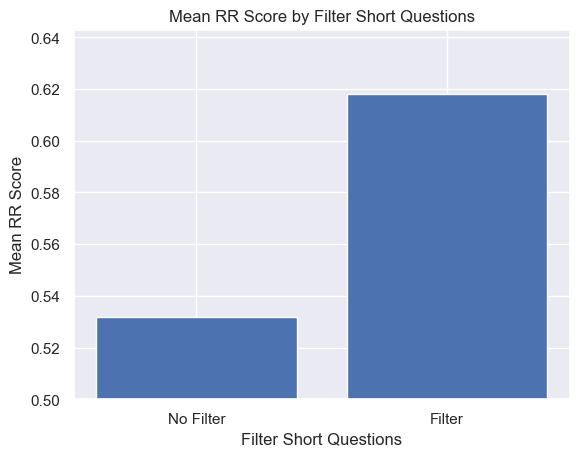

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set seaborn theme (choose a theme from 'darkgrid', 'whitegrid', 'dark', 'white', 'classic', 'light', 'dark_background')
sns.set_theme(style="darkgrid")  # Example theme, choose one you prefer

temp1 = score_summary[["mean_rr_score","filter_short_qs"]].group_by("filter_short_qs").agg(pl.mean("mean_rr_score")).sort("filter_short_qs")
temp2 = score_summary[["mean_mext_rr_score","filter_short_qs"]].group_by("filter_short_qs").agg(pl.mean("mean_mext_rr_score")).sort("filter_short_qs")
temp3 = score_summary[["mean_dcg_score","filter_short_qs"]].group_by("filter_short_qs").agg(pl.mean("mean_dcg_score")).sort("filter_short_qs")

score_to_plot = "mean_rr_score"
score_readable = "Mean RR Score"

x = ["No Filter", "Filter"]
y = temp1[score_to_plot].to_numpy()

plt.bar(x, y)
plt.xlabel("Filter Short Questions")
plt.ylabel(score_readable)
plt.ylim(.5, max(y) + .025)
plt.title(score_readable+" by Filter Short Questions")
plt.savefig("../images/rr_score_filter_short_qs.png")
plt.show()


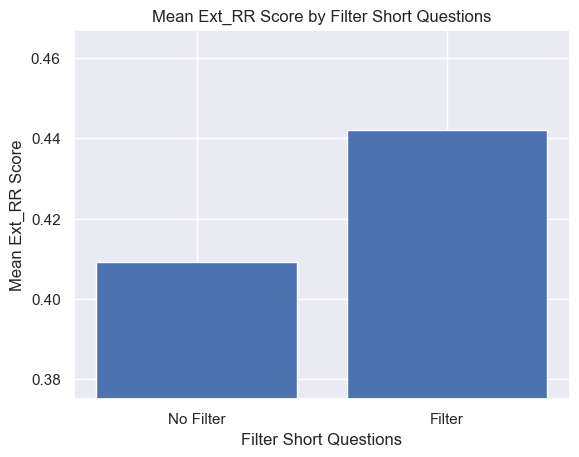

In [16]:
score_to_plot = "mean_mext_rr_score"
score_readable = "Mean Ext_RR Score"

x = ["No Filter", "Filter"]
y = temp2[score_to_plot].to_numpy()

plt.bar(x, y)
plt.xlabel("Filter Short Questions")
plt.ylabel(score_readable)
plt.ylim(.375, max(y) + .025)
plt.title(score_readable+" by Filter Short Questions")
plt.savefig("../images/mext_rr_score_filter_short_qs.png")
plt.show()



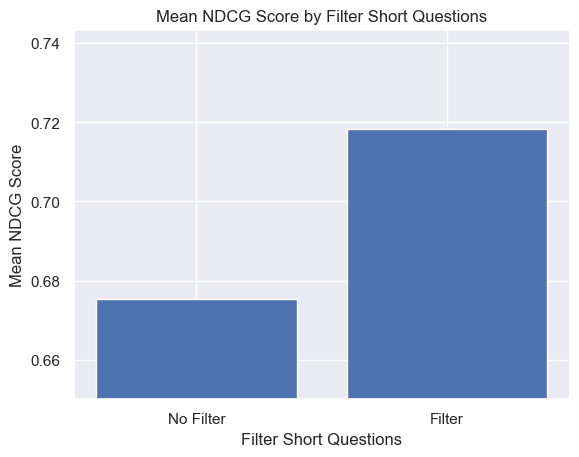

In [17]:
score_to_plot = "mean_dcg_score"
score_readable = "Mean NDCG Score"

x = ["No Filter", "Filter"]
y = temp3[score_to_plot].to_numpy()

plt.bar(x, y)
plt.xlabel("Filter Short Questions")
plt.ylabel(score_readable)
plt.ylim(.65, max(y) + .025)
plt.title(score_readable+" by Filter Short Questions")
plt.savefig("../images/dcg_score_filter_short_qs.png")
plt.show()

### Visualizing the Effect of Chunk Size and Attaching Metadata

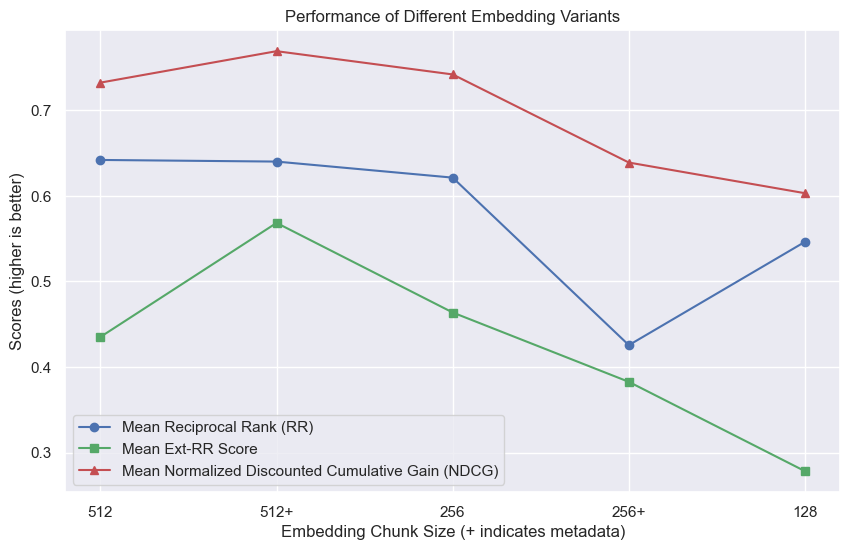

In [18]:
embedding_scores = score_summary[["mean_rr_score",
                                  "mean_mext_rr_score", 
                                  "mean_dcg_score", "emb"]
                                  ].group_by("emb").mean().sort(by="emb")

x = ["512", "512+", "256", "256+", "128"]
rr_scores = embedding_scores["mean_rr_score"].to_list()
mext_rr_scores = embedding_scores["mean_mext_rr_score"].to_list()
dcg_scores = embedding_scores["mean_dcg_score"].to_list()

# Create the line chart
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability

# Plot lines for each metric with different colors and labels
plt.plot(x, rr_scores, label='Mean Reciprocal Rank (RR)', marker='o', color='b')
plt.plot(x, mext_rr_scores, label='Mean Ext-RR Score', marker='s', color='g')
plt.plot(x, dcg_scores, label='Mean Normalized Discounted Cumulative Gain (NDCG)', marker='^', color='r')

# Add labels, title, legend, and grid
plt.xlabel('Embedding Chunk Size (+ indicates metadata)')
plt.ylabel('Scores (higher is better)')
plt.title('Performance of Different Embedding Variants')
plt.legend()
plt.grid(True)

## Save the chart
plt.savefig("../images/embedding_scores.png")

# Display the chart
plt.show()

### Visualizing the Performance of Our Top Configuration Relative to Baseline

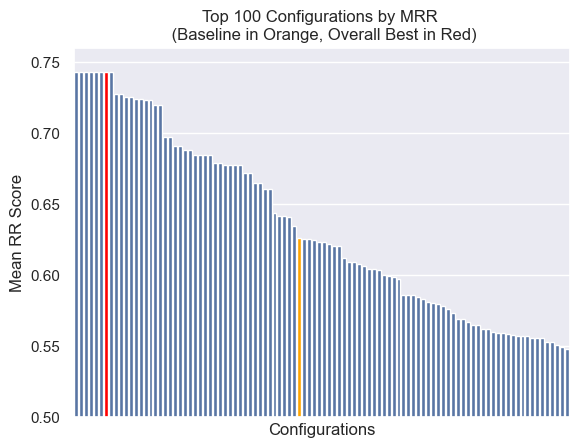

In [19]:
config_codes = score_summary.sort("mean_rr_score", descending=True)["config_code"].to_list()[0:100]
rr_scores = score_summary.sort("mean_rr_score", descending=True)["mean_rr_score"].to_list()[0:100]
mext_rr_scores = score_summary.sort("mean_rr_score", descending=True)["mean_mext_rr_score"].to_list()[0:100]
dcg_scores = score_summary.sort("mean_rr_score", descending=True)["mean_dcg_score"].to_list()[0:100]
baseline_index = score_summary.sort("mean_rr_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="000000000")["index"][0]
best_index = score_summary.sort("mean_rr_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="010010110")["index"][0]

data = {
    "config_code": config_codes,
    "mean_rr_score": rr_scores,
    "mean_mext_rr_score": mext_rr_scores,
    "mean_dcg_score": dcg_scores
}

# Create a DataFrame from the dictionary
df = pl.DataFrame(data)

# Set seaborn theme (optional, choose a theme you prefer)
# sns.set_theme(style="darkgrid")  # Example theme

# Create a violin plot (or other plot type as desired)
bars = sns.barplot(x="config_code", y="mean_rr_score", data=df)  # Adjust y as needed for other scores

# Set the color of the target bar to red
bars.patches[baseline_index].set_facecolor('orange')
bars.patches[best_index].set_facecolor('red')

## Turn off x-ticks
plt.xticks([])
# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=90)  # Adjust rotation angle if needed

## Set y-axis limits
plt.ylim(.5, .76)  # Adjust limits based on chosen y variable

# Add labels and title
plt.xlabel("Configurations")
plt.ylabel("Mean RR Score")  # Adjust label based on chosen y variable
plt.title("Top 100 Configurations by MRR \n (Baseline in Orange, Overall Best in Red)")

## Save the plot
plt.savefig("../images/top_100_rr_scores.png")

# Show the plot
plt.show()

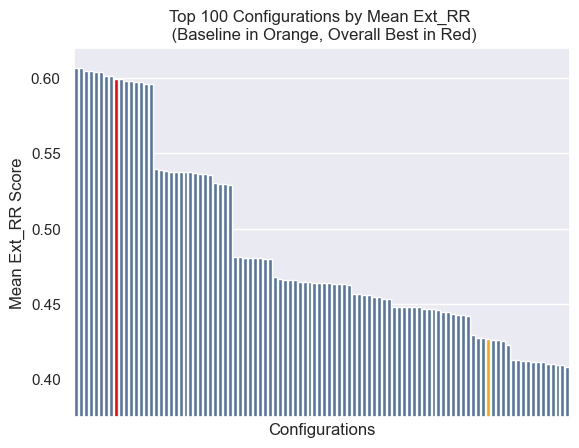

In [20]:
config_codes = score_summary.sort("mean_mext_rr_score", descending=True)["config_code"].to_list()[0:100]
rr_scores = score_summary.sort("mean_mext_rr_score", descending=True)["mean_rr_score"].to_list()[0:100]
mext_rr_scores = score_summary.sort("mean_mext_rr_score", descending=True)["mean_mext_rr_score"].to_list()[0:100]
dcg_scores = score_summary.sort("mean_mext_rr_score", descending=True)["mean_dcg_score"].to_list()[0:100]
baseline_index = score_summary.sort("mean_mext_rr_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="000000000")["index"][0]
best_index = score_summary.sort("mean_mext_rr_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="010010110")["index"][0]

data = {
    "config_code": config_codes,
    "mean_rr_score": rr_scores,
    "mean_mext_rr_score": mext_rr_scores,
    "mean_dcg_score": dcg_scores
}

# Create a DataFrame from the dictionary
df = pl.DataFrame(data)

# Set seaborn theme (optional, choose a theme you prefer)
# sns.set_theme(style="darkgrid")  # Example theme

# Create a violin plot (or other plot type as desired)
bars = sns.barplot(x="config_code", y="mean_mext_rr_score", data=df)  # Adjust y as needed for other scores

# Set the color of the target bar to red
bars.patches[baseline_index].set_facecolor('orange')
bars.patches[best_index].set_facecolor('red')

## Turn off x-ticks
plt.xticks([])
# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=90)  # Adjust rotation angle if needed

## Set y-axis limits
plt.ylim(.375, .62)  # Adjust limits based on chosen y variable

# Add labels and title
plt.xlabel("Configurations")
plt.ylabel("Mean Ext_RR Score")  # Adjust label based on chosen y variable
plt.title("Top 100 Configurations by Mean Ext_RR \n (Baseline in Orange, Overall Best in Red)")

## Save the plot
plt.savefig("../images/top_100_mext_rr_scores.png")

# Show the plot
plt.show()

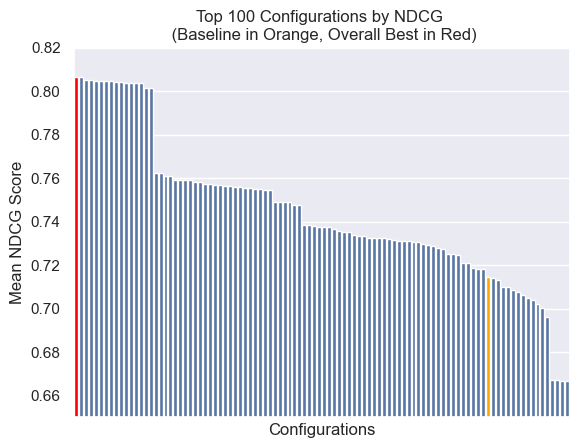

In [21]:
config_codes = score_summary.sort("mean_dcg_score", descending=True)["config_code"].to_list()[0:100]
rr_scores = score_summary.sort("mean_dcg_score", descending=True)["mean_rr_score"].to_list()[0:100]
mext_rr_scores = score_summary.sort("mean_dcg_score", descending=True)["mean_mext_rr_score"].to_list()[0:100]
dcg_scores = score_summary.sort("mean_dcg_score", descending=True)["mean_dcg_score"].to_list()[0:100]
baseline_index = score_summary.sort("mean_dcg_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="000000000")["index"][0]
best_index = score_summary.sort("mean_dcg_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="010010110")["index"][0]

data = {
    "config_code": config_codes,
    "mean_rr_score": rr_scores,
    "mean_mext_rr_score": mext_rr_scores,
    "mean_dcg_score": dcg_scores
}

# Create a DataFrame from the dictionary
df = pl.DataFrame(data)

# Set seaborn theme (optional, choose a theme you prefer)
# sns.set_theme(style="darkgrid")  # Example theme

# Create a violin plot (or other plot type as desired)
bars = sns.barplot(x="config_code", y="mean_dcg_score", data=df)  # Adjust y as needed for other scores

# Set the color of the target bar to red
bars.patches[baseline_index].set_facecolor('orange')
bars.patches[best_index].set_facecolor('red')

## Turn off x-ticks
plt.xticks([])
# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=90)  # Adjust rotation angle if needed

## Set y-axis limits
plt.ylim(.65, .82)  # Adjust limits based on chosen y variable

# Add labels and title
plt.xlabel("Configurations")
plt.ylabel("Mean NDCG Score")  # Adjust label based on chosen y variable
plt.title("Top 100 Configurations by NDCG \n (Baseline in Orange, Overall Best in Red)")

## Save the plot
plt.savefig("../images/top_100_dcg_scores.png")

# Show the plot
plt.show()

### Visualizing Combined Effects

We notice that configuration that 1) were embedded with a chunk size of 512, 2) had metdadate attached before embedding, and 3) filtered out short questions before retrieval performed particularly well.

We can visualize this in each metric by highlighting these configurations. 

In [22]:
configs_with_condition = [
    "010010000",
    "010010001",
    "010010010",
    "010010011",
    "010010100",
    "010010101",
    "010010110",
    "010010111",
    "010011000",
    "010011001",
    "010011010",
    "010011011",
    "010011100",
    "010011101",
    "010011110",
    "010011111"]

rr_conditions = score_summary\
    .sort("mean_rr_score", descending=True)[["config_code"]]\
    .with_row_index()[["index","config_code"]]\
        .filter(pl.col("config_code").is_in(configs_with_condition))["index"]\
            .to_list()

mext_rr_conditions = score_summary\
    .sort("mean_mext_rr_score", descending=True)[["config_code"]]\
    .with_row_index()[["index","config_code"]]\
        .filter(pl.col("config_code").is_in(configs_with_condition))["index"]\
            .to_list()

dcg_conditions = score_summary\
    .sort("mean_dcg_score", descending=True)[["config_code"]]\
    .with_row_index()[["index","config_code"]]\
        .filter(pl.col("config_code").is_in(configs_with_condition))["index"]\
            .to_list()

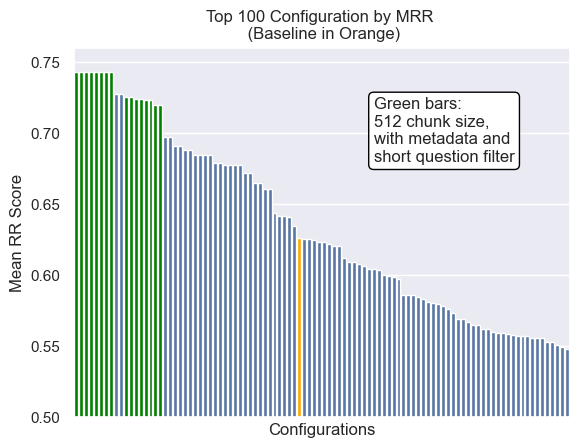

In [23]:
config_codes = score_summary.sort("mean_rr_score", descending=True)["config_code"].to_list()[0:100]
rr_scores = score_summary.sort("mean_rr_score", descending=True)["mean_rr_score"].to_list()[0:100]
mext_rr_scores = score_summary.sort("mean_rr_score", descending=True)["mean_mext_rr_score"].to_list()[0:100]
dcg_scores = score_summary.sort("mean_rr_score", descending=True)["mean_dcg_score"].to_list()[0:100]
baseline_index = score_summary.sort("mean_rr_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="000000000")["index"][0]
best_index = score_summary.sort("mean_rr_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="010010110")["index"][0]

data = {
    "config_code": config_codes,
    "mean_rr_score": rr_scores,
    "mean_mext_rr_score": mext_rr_scores,
    "mean_dcg_score": dcg_scores
}

# Create a DataFrame from the dictionary
df = pl.DataFrame(data)

# Set seaborn theme (optional, choose a theme you prefer)
# sns.set_theme(style="darkgrid")  # Example theme

# Create a violin plot (or other plot type as desired)
bars = sns.barplot(x="config_code", y="mean_rr_score", data=df)  # Adjust y as needed for other scores

# Set the color of the target bar to red
for index in rr_conditions:
    bars.patches[index].set_facecolor('green')

bars.patches[baseline_index].set_facecolor('orange')


## Turn off x-ticks
plt.xticks([])
# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=90)  # Adjust rotation angle if needed

## Set y-axis limits
plt.ylim(.5, .76)  # Adjust limits based on chosen y variable

# Add labels and title
plt.text(60,
         .68,
         "Green bars: \n512 chunk size, \nwith metadata and\nshort question filter", 
         bbox=dict(boxstyle="round", ec=(0.0, 0.0, 0.0), fc=(1., 1, 1))
         )
plt.xlabel("Configurations")
plt.ylabel("Mean RR Score")  # Adjust label based on chosen y variable
plt.title("Top 100 Configuration by MRR \n (Baseline in Orange)")

## Save the plot
plt.savefig("../images/top_100_rr_scores_with_conditions.png")

# Show the plot
plt.show()

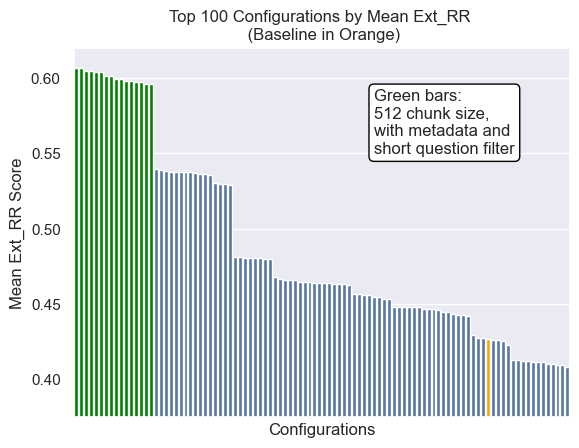

In [24]:
config_codes = score_summary.sort("mean_mext_rr_score", descending=True)["config_code"].to_list()[0:100]
rr_scores = score_summary.sort("mean_mext_rr_score", descending=True)["mean_rr_score"].to_list()[0:100]
mext_rr_scores = score_summary.sort("mean_mext_rr_score", descending=True)["mean_mext_rr_score"].to_list()[0:100]
dcg_scores = score_summary.sort("mean_mext_rr_score", descending=True)["mean_dcg_score"].to_list()[0:100]
baseline_index = score_summary.sort("mean_mext_rr_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="000000000")["index"][0]
best_index = score_summary.sort("mean_mext_rr_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="010010110")["index"][0]

data = {
    "config_code": config_codes,
    "mean_rr_score": rr_scores,
    "mean_mext_rr_score": mext_rr_scores,
    "mean_dcg_score": dcg_scores
}

# Create a DataFrame from the dictionary
df = pl.DataFrame(data)

# Set seaborn theme (optional, choose a theme you prefer)
# sns.set_theme(style="darkgrid")  # Example theme

# Create a violin plot (or other plot type as desired)
bars = sns.barplot(x="config_code", y="mean_mext_rr_score", data=df)  # Adjust y as needed for other scores

for index in mext_rr_conditions:
    bars.patches[index].set_facecolor('green')

bars.patches[baseline_index].set_facecolor('orange')

## Turn off x-ticks
plt.xticks([])
# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=90)  # Adjust rotation angle if needed

## Set y-axis limits
plt.ylim(.375, .62)  # Adjust limits based on chosen y variable

# Add labels and title
plt.text(60,
         .55,
         "Green bars: \n512 chunk size, \nwith metadata and\nshort question filter", 
         bbox=dict(boxstyle="round", ec=(0.0, 0.0, 0.0), fc=(1., 1, 1))
         )
plt.xlabel("Configurations")
plt.ylabel("Mean Ext_RR Score")  # Adjust label based on chosen y variable
plt.title("Top 100 Configurations by Mean Ext_RR \n (Baseline in Orange)")

## Save the plot
plt.savefig("../images/top_100_mext_rr_scores_with_condition.png")

# Show the plot
plt.show()

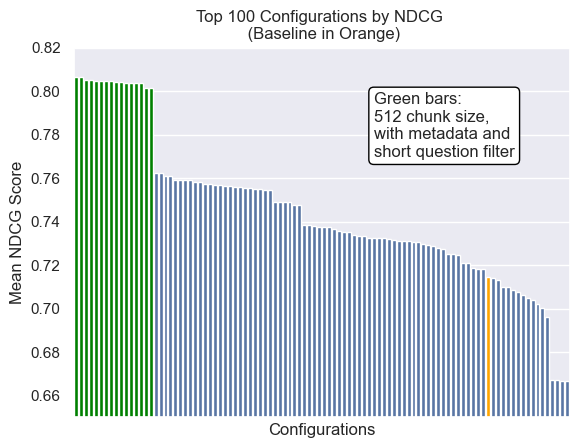

In [25]:
config_codes = score_summary.sort("mean_dcg_score", descending=True)["config_code"].to_list()[0:100]
rr_scores = score_summary.sort("mean_dcg_score", descending=True)["mean_rr_score"].to_list()[0:100]
mext_rr_scores = score_summary.sort("mean_dcg_score", descending=True)["mean_mext_rr_score"].to_list()[0:100]
dcg_scores = score_summary.sort("mean_dcg_score", descending=True)["mean_dcg_score"].to_list()[0:100]
baseline_index = score_summary.sort("mean_dcg_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="000000000")["index"][0]
best_index = score_summary.sort("mean_dcg_score", descending=True)[["config_code"]].with_row_index().filter(pl.col("config_code")=="010010110")["index"][0]

data = {
    "config_code": config_codes,
    "mean_rr_score": rr_scores,
    "mean_mext_rr_score": mext_rr_scores,
    "mean_dcg_score": dcg_scores
}

# Create a DataFrame from the dictionary
df = pl.DataFrame(data)

# Set seaborn theme (optional, choose a theme you prefer)
# sns.set_theme(style="darkgrid")  # Example theme

# Create a violin plot (or other plot type as desired)
bars = sns.barplot(x="config_code", y="mean_dcg_score", data=df)  # Adjust y as needed for other scores

for index in dcg_conditions:
    bars.patches[index].set_facecolor('green')

bars.patches[baseline_index].set_facecolor('orange')

## Turn off x-ticks
plt.xticks([])
# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=90)  # Adjust rotation angle if needed

## Set y-axis limits
plt.ylim(.65, .82)  # Adjust limits based on chosen y variable

# Add labels and title
plt.text(60,
         .77,
         "Green bars: \n512 chunk size, \nwith metadata and\nshort question filter", 
         bbox=dict(boxstyle="round", ec=(0.0, 0.0, 0.0), fc=(1., 1, 1))
         )
plt.xlabel("Configurations")
plt.ylabel("Mean NDCG Score")  # Adjust label based on chosen y variable
plt.title("Top 100 Configurations by NDCG \n (Baseline in Orange)")

## Save the plot
plt.savefig("../images/top_100_dcg_scores_with_conditions.png")

# Show the plot
plt.show()